In [1]:
import pandas as pd
import numpy as np
from pandas import DataFrame, Series
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.preprocessing import Normalizer, StandardScaler, RobustScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt
import seaborn as sns
import re


C:\apps\anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# MovieLens 데이터 : 영화정보
* 영화ID / 제목 / 장르 로 구성되어 있음

In [2]:
### Movie Information Dataset

file_path = './data/' + 'movies.csv'
df_movie = pd.read_csv(file_path)
df_movie.head()


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


# MovieLens 데이터 : 레이팅
* 유저ID / 영화ID / 레이팅 / 시간 으로 구성되어 있음
* 시간은 여기에서 사용하지 않음

In [3]:
### Movie Rating Dataset

file_path = './data/' + 'ratings.csv'
df_rating = pd.read_csv(file_path)
df_rating.head()


,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


# 해당 데이터에는 19개의 영화장르가 있음
* 클러스터링시 장르별 평점을 Feature로 사용하여 군집화 진행

In [4]:
### Movie Genre List

genre_full = df_movie['genres'].str.split('|').tolist()
genre_list = []

for genre_single in genre_full:
    for ix in genre_single:
        genre_list.append(ix)

genre_list = list(set(genre_list))
genre_list.remove('(no genres listed)')
genre_list


['War',
 'Crime',
 'Fantasy',
 'Musical',
 'Film-Noir',
 'Thriller',
 'Adventure',
 'Animation',
 'Drama',
 'Action',
 'Sci-Fi',
 'Western',
 'Comedy',
 'Horror',
 'Mystery',
 'Romance',
 'IMAX',
 'Documentary',
 'Children']

In [5]:
### Generate Rating By Genres

cols = ['movieId', 'genres']
df_rating = df_rating.merge(df_movie[cols], on='movieId', how='left')

def filterGenre(word, strings):
    if re.search(word, strings):
        val_return = 1
    else:
        val_return = None
    return val_return

for ix in genre_list:
    val = df_rating.apply(lambda x: filterGenre(ix, x['genres']), axis=1)
    df_rating[ix] = val * df_rating['rating']

df_rating.head(15)


,userId,movieId,rating,timestamp,genres,War,Crime,Fantasy,Musical,Film-Noir,...,Action,Sci-Fi,Western,Comedy,Horror,Mystery,Romance,IMAX,Documentary,Children
0,1,1,4.0,964982703,Adventure|Animation|Children|Comedy|Fantasy,NaN,NaN,4.0,NaN,NaN,...,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,4.0
1,1,3,4.0,964981247,Comedy|Romance,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,4.0,NaN,NaN,4.0,NaN,NaN,NaN
2,1,6,4.0,964982224,Action|Crime|Thriller,NaN,4.0,NaN,NaN,NaN,...,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,47,5.0,964983815,Mystery|Thriller,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN
4,1,50,5.0,964982931,Crime|Mystery|Thriller,NaN,5.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN
5,1,70,3.0,964982400,Action|Comedy|Horror|Thriller,NaN,NaN,NaN,NaN,NaN,...,3.0,NaN,NaN,3.0,3.0,NaN,NaN,NaN,NaN,NaN
6,1,101,5.0,964980868,Adventure|Comedy|Crime|Romance,NaN,5.0,NaN,NaN,NaN,...,NaN,NaN,NaN,5.0,NaN,NaN,5.0,NaN,NaN,NaN
7,1,110,4.0,964982176,Action|Drama|War,4.0,NaN,NaN,NaN,NaN,...,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,1,151,5.0,964984041,Action|Drama|Romance|War,5.0,NaN,NaN,NaN,NaN,...,5.0,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN
9,1,157,5.0,964984100,Comedy|War,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN


# 유저ID별 장르의 평균 레이팅 계산
* 개별 유저들의 장르 평균점수를 기본자료로 하여, 유저 간 유사도를 계산
* 유사한 유저간 클러스터링이 가능함

In [6]:
### Aggregate Genres Rating By User ID

df_matrix = df_rating.groupby(['userId'])[genre_list].mean().fillna(0)
df_matrix.head(10)


,War,Crime,Fantasy,Musical,Film-Noir,Thriller,Adventure,Animation,Drama,Action,Sci-Fi,Western,Comedy,Horror,Mystery,Romance,IMAX,Documentary,Children
userId,,,,,,,,,,,,,,,,,,,
1,4.500000,4.355556,4.297872,4.681818,5.00,4.145455,4.388235,4.689655,4.529412,4.322222,4.225000,4.285714,4.277108,3.470588,4.166667,4.307692,0.000000,0.000000,4.547619
2,4.500000,3.800000,0.000000,0.000000,0.00,3.700000,4.166667,0.000000,3.882353,3.954545,3.875000,3.500000,4.000000,3.000000,4.000000,4.500000,3.750000,4.333333,0.000000
3,0.500000,0.500000,3.375000,0.500000,0.00,4.142857,2.727273,0.500000,0.750000,3.571429,4.200000,0.000000,1.000000,4.687500,5.000000,0.500000,0.000000,0.000000,0.500000
4,3.571429,3.814815,3.684211,4.000000,4.00,3.552632,3.655172,4.000000,3.483333,3.320000,2.833333,3.800000,3.509615,4.250000,3.478261,3.379310,3.000000,4.000000,3.800000
5,3.333333,3.833333,4.142857,4.400000,0.00,3.555556,3.250000,4.333333,3.800000,3.111111,2.500000,3.000000,3.466667,3.000000,4.000000,3.090909,3.666667,0.000000,4.111111
6,3.583333,3.285714,3.538462,4.166667,2.50,3.544118,3.893617,4.071429,3.614286,3.609375,3.476190,3.818182,3.370079,3.263158,3.733333,3.614286,4.666667,0.000000,3.617021
7,3.291667,3.307692,3.065217,3.666667,3.25,3.430233,3.314815,3.392857,3.131579,3.257812,3.154762,1.500000,3.163265,4.000000,3.178571,2.650000,2.454545,0.000000,3.200000
8,3.666667,3.888889,3.250000,5.000000,0.00,3.750000,3.545455,5.000000,3.789474,3.333333,3.250000,3.000000,3.208333,4.500000,4.000000,3.500000,4.500000,0.000000,4.250000
9,3.500000,3.142857,5.000000,3.000000,4.00,2.545455,3.800000,4.000000,3.428571,3.125000,3.000000,4.000000,3.666667,1.800000,4.000000,3.166667,3.000000,0.000000,4.000000


# Hierarchical Clustering : 유클리드 vs 코사인 거리
* Bottom-Up 방식의 계층군집화를 통해서, 유사한 유저를 묶을 수 있음
* 아래와 각 유사도 계산에는 측정방법이 다양히 존재함 (단 Ward는 유클리드에서만 계산 가능)
* 유사도 계산의 조합에 따라서 매우 다양한 클러스터링 결과가 나타남

#### 코사인 거리의 경우 Collaborative Filtering에서 많이 사용
#### 실제 클러스터링에는 유클리드 + Ward + 3개 군집으로 진행 예정

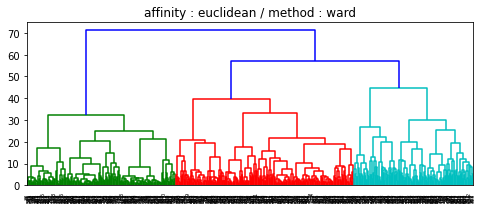

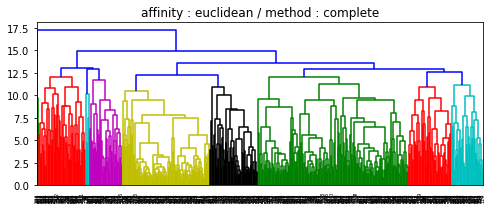

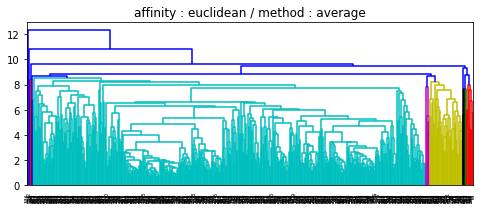

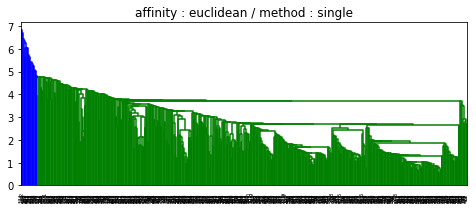

In [8]:
### Dendrogram : Euclidean

aug_affinity = 'euclidean'
aug_methods = ['ward', 'complete', 'average', 'single']

for aug_method in aug_methods:
    plt.figure(figsize=(8, 3))
    plt.title('affinity : {} / method : {}'.format(aug_affinity, aug_method))
    hier_link = sch.linkage(df_matrix, metric=aug_affinity, method=aug_method)
    hier_dend = sch.dendrogram(hier_link)
    plt.show()


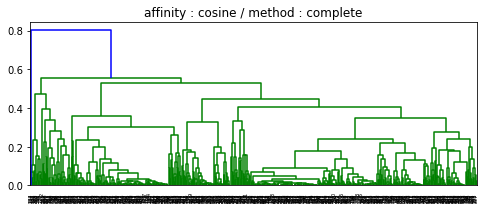

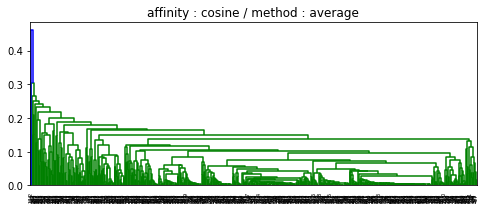

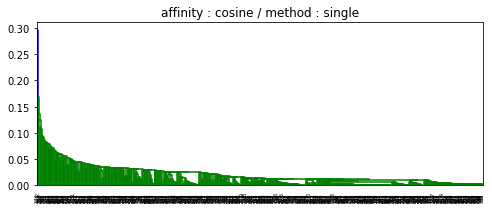

In [9]:
### Dendrogram : Cosine

aug_affinity = 'cosine'
aug_methods = ['complete', 'average', 'single']

for aug_method in aug_methods:
    plt.figure(figsize=(8, 3))
    plt.title('affinity : {} / method : {}'.format(aug_affinity, aug_method))
    hier_link = sch.linkage(df_matrix, metric=aug_affinity, method=aug_method)
    hier_dend = sch.dendrogram(hier_link)
    plt.show()


# 클러스터링
* 유클리드거리 / Ward / 3개 군집으로 계층적 군집화를 진행함
* 클러스터링은 쉽지만, 해석은 어려움! (Making clustering is easy, interpreting is hard!)

In [7]:
### Clustering

n_cluster = 3
array_matrix = df_matrix.values
aug1 = 'euclidean'
aug2 = 'ward'

clustering = AgglomerativeClustering(n_clusters=n_cluster,
                                     affinity=aug1, linkage=aug2)

array_cluster = clustering.fit_predict(array_matrix)
df_matrix['cluster'] = array_cluster
df_matrix.head(10)


,War,Crime,Fantasy,Musical,Film-Noir,Thriller,Adventure,Animation,Drama,Action,Sci-Fi,Western,Comedy,Horror,Mystery,Romance,IMAX,Documentary,Children,cluster
userId,,,,,,,,,,,,,,,,,,,,
1,4.500000,4.355556,4.297872,4.681818,5.00,4.145455,4.388235,4.689655,4.529412,4.322222,4.225000,4.285714,4.277108,3.470588,4.166667,4.307692,0.000000,0.000000,4.547619,1
2,4.500000,3.800000,0.000000,0.000000,0.00,3.700000,4.166667,0.000000,3.882353,3.954545,3.875000,3.500000,4.000000,3.000000,4.000000,4.500000,3.750000,4.333333,0.000000,2
3,0.500000,0.500000,3.375000,0.500000,0.00,4.142857,2.727273,0.500000,0.750000,3.571429,4.200000,0.000000,1.000000,4.687500,5.000000,0.500000,0.000000,0.000000,0.500000,0
4,3.571429,3.814815,3.684211,4.000000,4.00,3.552632,3.655172,4.000000,3.483333,3.320000,2.833333,3.800000,3.509615,4.250000,3.478261,3.379310,3.000000,4.000000,3.800000,1
5,3.333333,3.833333,4.142857,4.400000,0.00,3.555556,3.250000,4.333333,3.800000,3.111111,2.500000,3.000000,3.466667,3.000000,4.000000,3.090909,3.666667,0.000000,4.111111,2
6,3.583333,3.285714,3.538462,4.166667,2.50,3.544118,3.893617,4.071429,3.614286,3.609375,3.476190,3.818182,3.370079,3.263158,3.733333,3.614286,4.666667,0.000000,3.617021,1
7,3.291667,3.307692,3.065217,3.666667,3.25,3.430233,3.314815,3.392857,3.131579,3.257812,3.154762,1.500000,3.163265,4.000000,3.178571,2.650000,2.454545,0.000000,3.200000,1
8,3.666667,3.888889,3.250000,5.000000,0.00,3.750000,3.545455,5.000000,3.789474,3.333333,3.250000,3.000000,3.208333,4.500000,4.000000,3.500000,4.500000,0.000000,4.250000,2
9,3.500000,3.142857,5.000000,3.000000,4.00,2.545455,3.800000,4.000000,3.428571,3.125000,3.000000,4.000000,3.666667,1.800000,4.000000,3.166667,3.000000,0.000000,4.000000,1


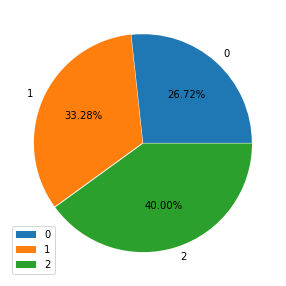

,cluster,count
0,0,163
1,1,203
2,2,244


In [25]:
### Clustering : Pie Plot
df_pie = df_matrix.groupby('cluster').agg({'Crime':'count'}).reset_index()
df_pie.rename(columns={'Crime':'count'}, inplace=True)

explodes = [0, .005, .005]

plt.figure(figsize=(5,5))
plt.pie(df_pie['count'], labels=df_pie['cluster'], autopct='%.2f%%', 
        explode=explodes)
plt.legend()
plt.show()

df_pie

# 클러스터링 해석
* 각 클러스터 별 장르 레이팅 평균을 숫자형 자료로 비교하는 것은 어려움
* 시각화를 통해서, 각 클러스터 별 차이점을 비교적 쉽게 확인 할 수 있음
* 반드시 도메인 전문가와 산출된 자료를 같이 판단해야함

In [11]:
### Aggregate By Clusters

cols = ['cluster']
cols_val = df_matrix.columns.tolist()[:-1]
df_agg = df_matrix.groupby(cols)[cols_val].mean()
df_agg


,Comedy,Drama,Horror,Animation,Romance,Mystery,Thriller,Crime,IMAX,Children,Action,Fantasy,Western,Musical,Adventure,Documentary,Sci-Fi,Film-Noir,War
cluster,,,,,,,,,,,,,,,,,,,
0,3.486066,3.690486,2.652243,1.997386,3.481222,3.231082,3.554623,3.640075,0.925042,2.266656,3.478705,3.089670,1.703304,1.933531,3.484506,0.707596,3.423215,0.848160,2.667971
1,3.534633,3.747375,3.374224,3.584476,3.599273,3.706991,3.593490,3.747621,3.262343,3.424474,3.494951,3.571803,3.127828,3.366958,3.555571,2.641126,3.477337,3.813076,3.852511
2,3.635635,3.808980,2.997225,3.545179,3.717232,3.693722,3.681370,3.737451,3.812193,3.631895,3.630562,3.495561,2.529759,2.821950,3.698616,0.784609,3.578609,0.031762,3.753026


# 클러스터링 히트맵
* 히트맵을 통해서 비교적 쉽게 자료해석이 가능해짐<br/><br/>

### 내 뇌피셜
* 클러스터 0 : 아주 대중적인 영화장르(코메디, 액션 등)에 치우쳐진 영화취향을 가지고 있음
* 클러스터 1 : 다큐멘터리(이것도 다른 클러스터보다 높음!)를 제외한 나머지 장르의 레이팅이 높음. 그리고 필름느와르의 레이팅이 높은 것은 특이함
* 클러스터 2 : 드라마, 코메디, 로맨스, 액션, 어드벤처의 레이팅이 다른 클러스터 보다 높음. 가족이 있거나 / 가족적인 유저 ?

#### 클러스터 별 레이팅의 평균은 전체를 대표하는 자료이지만, 클러스터 내 편차가 존재할 수 있기 때문에 세부적인 내용을 확인할 필요가 있음

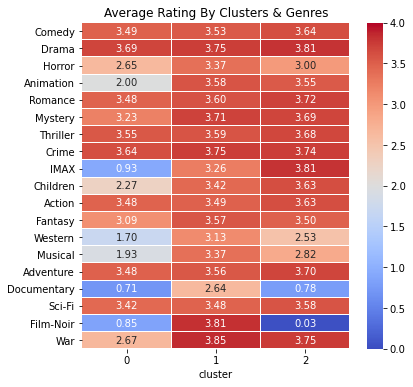

In [21]:
### Heatmap : Aggregate By Clusters

plt.figure(figsize=(6, 6))
sns.heatmap(df_agg.T, cmap='coolwarm', vmax=4, vmin=0, linewidths=.01,
            annot=True, fmt='.2f')
plt.title('Average Rating By Clusters & Genres', fontsize=12)
plt.show()


In [29]:
### Count UserID By Clusters With Rating Bins

v1 = -.0000000001
df_agg = DataFrame()

for ix in genre_list:
    df_temp = df_matrix[['cluster', ix]].copy()
    df_temp['bin'] = pd.cut(df_temp[ix], 
                            bins=[0+v1, 1+v1, 2+v1, 3+v1, 4+v1, 5+v1, 6+v1],
                            labels=[0, 1, 2, 3, 4, 5], include_lowest=False)
    cols = ['cluster', 'bin']
    df_agg_temp = df_temp.groupby(cols).agg({ix:'count'})
    df_agg = pd.concat([df_agg, df_agg_temp], axis=1)

df_agg.fillna(0, inplace=True)
df_agg


War  Crime  Fantasy  Musical  Film-Noir  Thriller  Adventure  \
cluster bin                                                                 
0       0     52      7       18       75        127         2          5   
        1      2      2        8        4          1         5          5   
        2     10     14       23       12          1        23         22   
        3     29     65       67       31         14        83         77   
        4     51     71       38       33         13        49         49   
        5     19      4        9        8          7         1          5   
1       0      1      0        0       14          5         0          0   
        1      0      0        1        1          2         0          1   
        2      8     16       24       23          8        22         24   
        3    104    126      133      108         74       135        146   
        4     86     61       44       55        100        46         31   
        5      4      0        1        2         14         0          1   
2       0      8      3        9       57        239         1          0   
        1      5      3        4        1          4         4          0   
        2     16     13       22       18          0        19         23   
        3     85    125      131       93          1       145        140   
        4    114     96       73       61          0        72         79   
        5     16      4        5       14          0         3          2   

             Animation  Drama  Action  Sci-Fi  Western  Comedy  Horror  \
cluster bin                                                              
0       0           70      1       5       6       86       1      37   
        1            6      3       4      10        3       4       6   
        2           12     13      22      23       10      24      22   
        3           34     87      86      65       24      99      58   
        4           35     58      44      56       33      34      32   
        5            6      1       2       3        7       1       8   
1       0            4      0       0       0       29       0       4   
        1            2      0       2       0        4       0       5   
        2           23     14      27      28       22      24      39   
        3          113    129     146     147       82     154     107   
        4           60     60      28      27       61      25      47   
        5            1      0       0       1        5       0       1   
2       0           15      0       0       2       77       0      41   
        1            2      1       1       0        0       1       7   
        2           18     10      22      37       16      23      33   
        3          102    142     154     129       76     156      83   
        4           95     90      66      73       61      61      63   
        5           12      1       1       3       14       3      17   

             Mystery  Romance  IMAX  Documentary  Children  
cluster bin                                                 
0       0         22        5   124          132        49  
        1          2        4     3            3        13  
        2         11       22     3            1        19  
        3         64       74     9            9        44  
        4         53       54    14           14        33  
        5         11        4    10            4         5  
1       0          0        0    23           62         3  
        1          0        1     3            2         6  
        2         15       24    18           11        31  
        3        124      138    92           57       109  
        4         64       40    60           62        53  
        5          0        0     7            9         1  
2       0         10        1     7          194         3  
        1          3        3     0            2         0  
        2      

# 클러스터링 히트맵 : 레이팅 x 영화장르 별 유저ID 카운트

### 내 뇌피셜
* 클러스터 0 : 아주 대중적인 영화장르(코메디, 액션 등)에 치우쳐진 영화취향을 가지고 있음<br/>
1) 다른 클러스터 대비 낮은 평점의 비중이 높은 편<br/>
2) 아이맥스, 다큐멘터리, 필름느와르를 매우 싫어한다는 것은 확실히 알겠음
<br/><br/>
* 클러스터 1 : 다큐멘터리(이것도 다른 클러스터보다 높음!)를 제외한 나머지 장르의 레이팅이 높음. 그리고 필름느와르의 레이팅이 높은 것은 특이함<br/>
1) 해당 클러스터는 중간 점수대인 3점대에 유저가 많이 몰려 있음<br/>
2) 다른 클러스터 대비해서 극점(0 / 5점) 비중이 낮은 것으로, 무난한 영화 취향을 가진 유저집합이라는 판단을 할 수 있음 (아님말고)<br/><br/>
* 클러스터 2 : 드라마, 코메디, 로맨스, 액션, 어드벤처의 레이팅이 다른 클러스터 보다 높음. 가족이 있거나 / 가족적인 유저 ?<br/>
1) 레이팅 구간 별로 확인했을 때, 4/5점대 유저의 비율이 상대적으로 높은 편을 확인할 수 있음 (관대한 유저들?)

#### 클러스터 해석은 같은 베이스 자료를 보더라도 "얼마나 깊이의 시각화를 하는가?", "어떠한 관점에서 해석을 하는가?" 에 따라서 달라질 수 있다

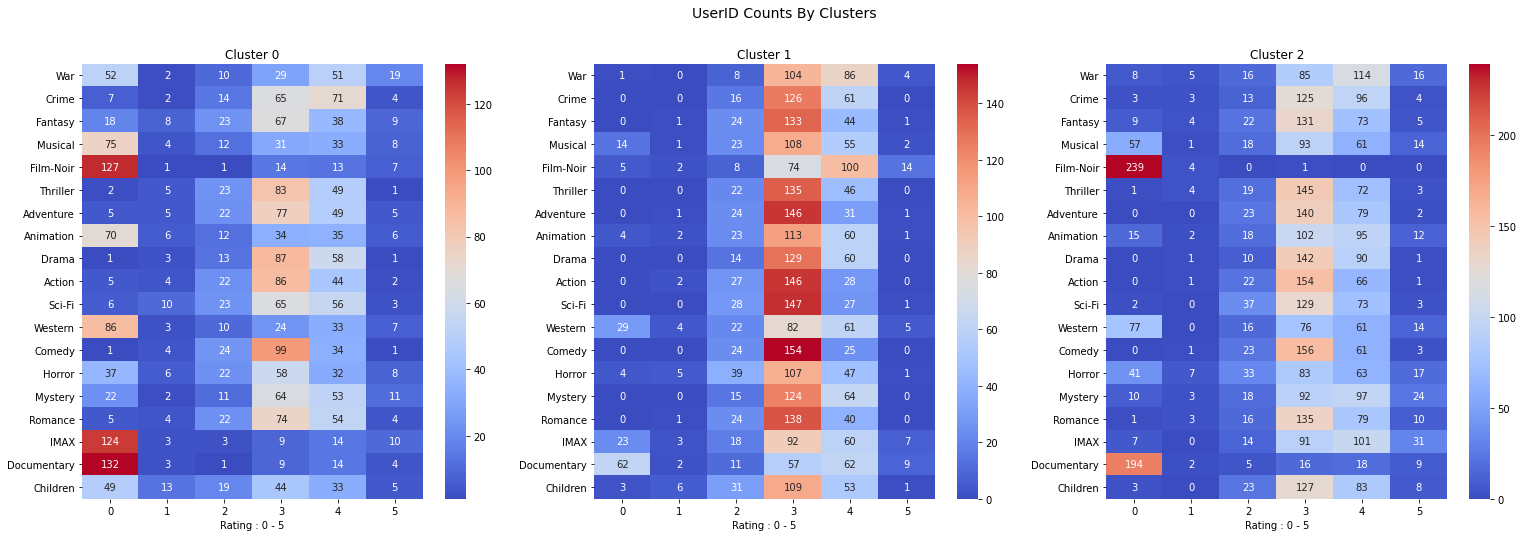

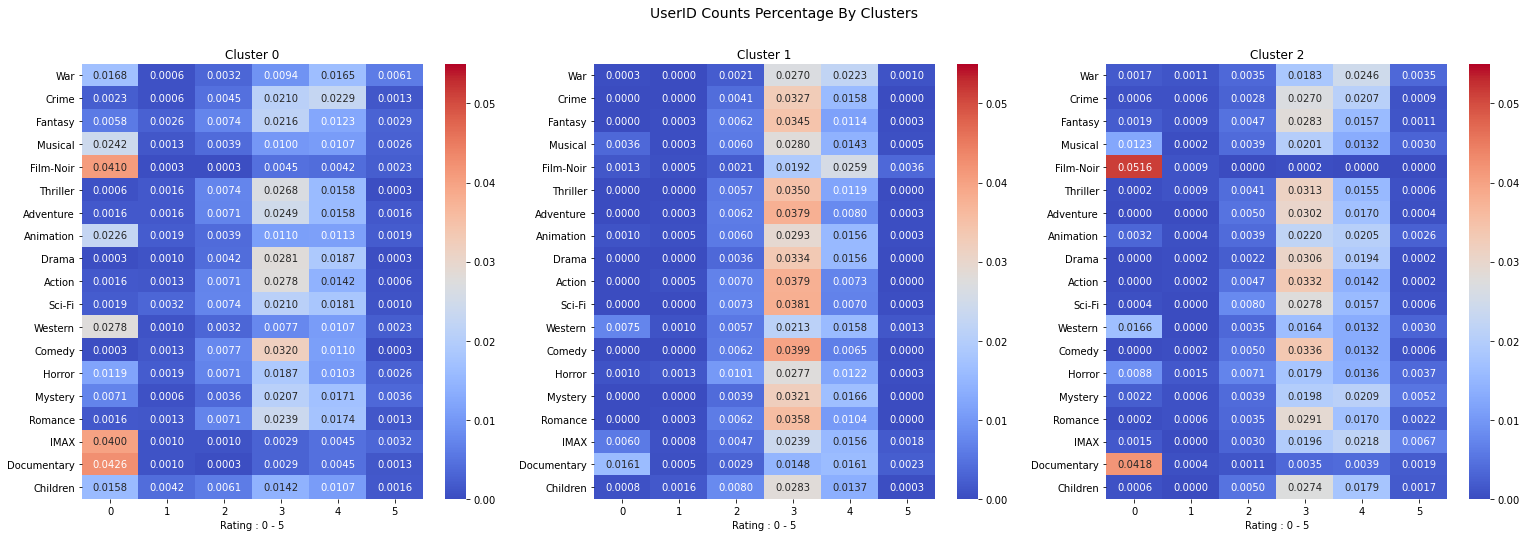

In [46]:
### Heatmap : Aggregate By Clusters With Rating Bins
fig, ax = plt.subplots(1, 3, figsize=(26, 8))
plt.suptitle('UserID Counts By Clusters', fontsize=14)
for ix in range(3):
    sns.heatmap(df_agg.loc[ix].T, cmap='coolwarm', ax=ax[ix], annot=True,
                fmt='d')
    ax[ix].set_title('Cluster {}'.format(ix), fontsize=12)
    ax[ix].set_xlabel('Rating : 0 - 5')

plt.show()

### Heatmap : Aggregate By Clusters With Rating Bins
fig, ax = plt.subplots(1, 3, figsize=(26, 8))
plt.suptitle('UserID Counts Percentage By Clusters', fontsize=14)
for ix in range(3):
    sns.heatmap(df_agg.loc[ix].T / df_agg.loc[ix].values.sum(), cmap='coolwarm',
                ax=ax[ix], annot=True, fmt='.4f', vmax=.055, vmin=0)
    ax[ix].set_title('Cluster {}'.format(ix), fontsize=12)
    ax[ix].set_xlabel('Rating : 0 - 5')

plt.show()
